In [81]:
import credentials # Api key is stored in this file, remove to avoid errors if you clone from github

import pvdeg
import pvlib
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy.linalg import cholesky

First get weather data and metadata for a desired location (latitude and logitude)

In [57]:
# change to desired values (currently Miami)
latitude = 25.783388
longitude = -80.189029

API_KEY = credentials.API_KEY # my personal NREL api key
email ='tobin.ford@nrel.gov' # replace these values with your appropriate information and remove or comment out first line (import credentials)

# reads NSRDB data 
WEATHER, METADATA = pvlib.iotools.get_psm3(latitude, longitude, API_KEY, email, names='tmy', map_variables=True)

print(METADATA)

{'Source': 'NSRDB', 'Location ID': '1060699', 'City': '-', 'State': '-', 'Country': '-', 'Time Zone': -5, 'Local Time Zone': -5, 'Dew Point Units': 'c', 'DHI Units': 'w/m2', 'DNI Units': 'w/m2', 'GHI Units': 'w/m2', 'Temperature Units': 'c', 'Pressure Units': 'mbar', 'Wind Direction Units': 'Degrees', 'Wind Speed Units': 'm/s', 'Surface Albedo Units': 'N/A', 'Version': '3.2.0', 'latitude': 25.77, 'longitude': -80.18, 'altitude': 0}


User has 3 parameters for initial implementation: See Kempe's "Deg Miami" tab in excel<br>



activation energy, Ea <br>
irradiance relation, x<br>
ln(R0)<br>

          *________________________________________*
          |             |            |             |
    Ea    |       1     |      a     |      b      |
          __________________________________________
          |             |            |             |
    x     |      a      |     1      |      c      |
          __________________________________________
          |             |            |             |
  ln(R0)  |      b      |     c      |      1      |
          __________________________________________
          *     Ea            X           ln(R0)   *

Notice symmetry across diagonal <br>

In [ ]:
# Correlation Coefficients
# user entered correlation coefficient
X_Ea = 
lnR0_Ea = 
lnR0_x = 

In [ ]:
# Activation Energy
mean_Ea = 129 # average
sd_Ea = 3.4 # standard deviation

# Irradiance relation
mean_X = 0.0341 # average
sd_X = 0.0992757 # standard deviation

# ln(R0)
mean_R0 = 13.7223084 
sd_R0 = 2.47334772

# generating standard distribution of points for each
samples_Ea, samples_X, samples_R0 = np.random.normal(mean_Ea, sd_Ea, 20_000), np.random.normal(mean_X, sd_X, 20_000), np.random.normal(mean_R0, sd_R0, 20_000)

Text(0.5, 1.0, '$R_0$')

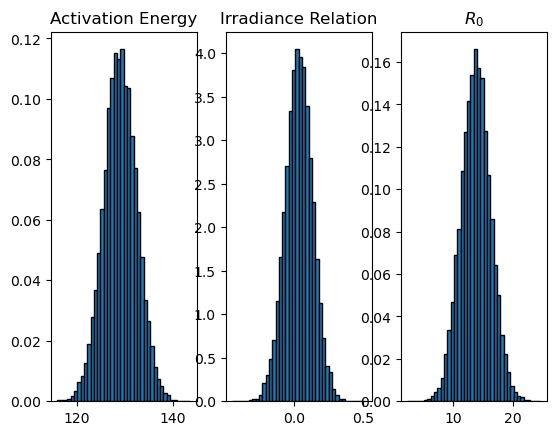

In [100]:
# spot check to view proper distribution
figure, axis = plt.subplots(1, 3)

axis[0].hist(samples_Ea, 40, density=True, edgecolor='black', label='Activation Energy')
axis[0].set_title("Activation Energy")

axis[1].hist(samples_X, 40, density=True, edgecolor='black', label='Activation Energy')
axis[1].set_title("Irradiance Relation")

axis[2].hist(samples_R0, 40, density=True, edgecolor='black', label='Activation Energy')
axis[2].set_title("$R_0$")


In [75]:
# users will enter parameters around here
# currently 3x3 but function works on NxN matricies
# fails if diagonal entry is negative :: -a_(n, n)
# because they should all be ones
text = [[1, 0.5, 0.4], 
        [0.5, 1, 0.2], 
        [0.4, 0.2, 1]]
A = np.array(text)

print(A)

post_cholesky = cholesky(A, lower=True)
print()
print(post_cholesky)


[[ 1.   0.5  0.4  0.3]
 [ 0.5  1.   0.2  0.1]
 [ 0.4  0.2  1.  -0.1]
 [ 0.3  0.1 -0.1  1. ]]

[[ 1.          0.          0.          0.        ]
 [ 0.5         0.8660254   0.          0.        ]
 [ 0.4         0.          0.91651514  0.        ]
 [ 0.3        -0.05773503 -0.24003968  0.9214378 ]]
